# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env restrict the behaviour of RL learner to pair trading only

## Import the Custom Trading Env

In [1]:
import os
import csv
import pickle
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt
from tqdm import trange
from stable_baselines3 import PPO, A2C, DDPG

from params import *
from utils.read2df import read2df, unify_dfs
from utils.clearlogs import clear_logs
from utils.rlmetrics import get_return, get_metrics
from envs.env_rl_restrict_thres import RL_RestrictFreeAmt_TradeEnv

folder_path = f"result/rl-restrict-thres-freeamt"
os.makedirs(folder_path, exist_ok=True)

## Prepare Trading Data
Load data from `preliminaries.ipynb`

In [2]:
with open('result/cointncorr.pickle', 'rb') as pk:
    cointncorr = pickle.load(pk)

with open('result/gridsearch/best_res.pickle', 'rb') as pk:
    best_profit, best_params = pickle.load(pk)

dfs = read2df(symbols=cointncorr[0], freqs={cointncorr[1]: freqs[cointncorr[1]]}, marketType='spot')
tics, df = unify_dfs(dfs, symbols=cointncorr[0], period=best_params['period'])

In [3]:
df.tail(10)

,time,close0,itvl,datetime,close1,spread,zscore
521369,1703818259999,0.000026,1m,2023-12-29 02:50:59.999,0.000028,-0.000002,0.083267
521370,1703818319999,0.000026,1m,2023-12-29 02:51:59.999,0.000028,-0.000002,0.082584
521371,1703818379999,0.000026,1m,2023-12-29 02:52:59.999,0.000028,-0.000002,0.063342
521372,1703818439999,0.000026,1m,2023-12-29 02:53:59.999,0.000028,-0.000002,0.088554
521373,1703818499999,0.000026,1m,2023-12-29 02:54:59.999,0.000028,-0.000002,0.086473
521374,1703818559999,0.000026,1m,2023-12-29 02:55:59.999,0.000028,-0.000002,0.224487
521375,1703818619999,0.000026,1m,2023-12-29 02:56:59.999,0.000028,-0.000002,0.257121
521376,1703818679999,0.000026,1m,2023-12-29 02:57:59.999,0.000028,-0.000002,0.291488
521377,1703818739999,0.000026,1m,2023-12-29 02:58:59.999,0.000028,-0.000002,0.536032
521378,1703818799999,0.000026,1m,2023-12-29 02:59:59.999,0.000028,-0.000002,1.049747


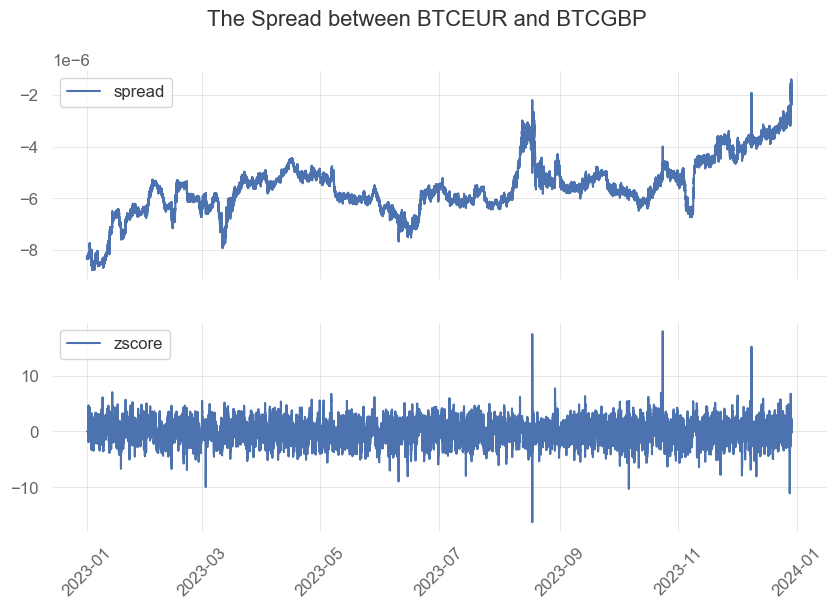

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(df['datetime'], df['spread'], label='spread')
ax2.plot(df['datetime'], df['zscore'], label='zscore')

ax1.legend()
ax2.legend()
plt.suptitle(f'The Spread between {cointncorr[0][0]} and {cointncorr[0][1]}')

plt.xticks(rotation=45)
plt.show()

In [5]:
train = df[(df['datetime'] >= datetime.strptime(start_date, date_format)) & (df['datetime'] < datetime.strptime(trade_date, date_format))]
test = df[(df['datetime'] >= datetime.strptime(trade_date, date_format)) & (df['datetime'] < datetime.strptime(end_date, date_format))]

max_train_len = int((len(train)-best_params['period']) * 0.95)
print(f"The length of our training data: {len(train)}")

The length of our training data: 87840


## Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [6]:
from stable_baselines3.common.env_checker import check_env

env = RL_RestrictFreeAmt_TradeEnv(train)
check_env(env)

c:\Users\hyan212\Miniconda3\envs\btrl\lib\site-packages\stable_baselines3\common\env_checker.py:452: UserWarning: Your action space has dtype float64, we recommend using np.float32 to avoid cast errors.
  warnings.warn(


In [7]:
test_env_expt = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_expt.csv", verbose=1)

try:
    os.remove(f"{folder_path}/networth_expt.csv")
except OSError:
    pass

obs, _ = test_env_expt.reset()

for i in trange(20):
    obs, rewards, terminated, truncated, info = test_env_expt.step(action=env.action_space.sample())
    # test_env_expt.render()

test_env_expt.close()

100%|██████████| 20/20 [00:00<00:00, 132.45it/s]

Finished
networth: 0.9912000528196021


Tensorboard

## Train the Model with Trading Env

In [8]:
log_path = f"logs/restrict_thres_freeamt/"
clear_logs(log_path)

# Read more about tensorboard
# https://github.com/tensorflow/tensorboard/blob/master/README.md
# https://www.tensorflow.org/tensorboard/get_started

Deleted: logs/restrict_thres_freeamt/A2C_1
Deleted: logs/restrict_thres_freeamt/PPO_1


In [9]:
'''PPO'''

model_ppo = PPO("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
model_ppo.learn(total_timesteps=max_train_len, progress_bar=False)
model_ppo.save(f"{folder_path}/ppo_pairtrading")

In [10]:
'''A2C'''

model_a2c = A2C("MultiInputPolicy", env, verbose=0, gamma=1, tensorboard_log=log_path)
model_a2c.learn(total_timesteps=max_train_len, progress_bar=True)
model_a2c.save(f"{folder_path}/a2c_pairtrading")

Output()

In [11]:
# '''
# DDPG
# '''

# model_ddpg = DDPG("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
# model_ddpg.learn(total_timesteps=max_train_len*0.95, progress_bar=True)
# model_ddpg.save(f"{folder_path}/dqn_pairtrading")

## Create the Custom Test Env

In [12]:
test_env_ppo = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_ppo.csv", verbose=1)
test_env_a2c = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_a2c.csv", verbose=1)
test_env_ddpg = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_ddpg.csv", verbose=1)
test_env_expt = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_expt.csv", verbose=1)

In [13]:
max_test_len = int(len(test) * 0.95 / 10)
print(f"The length of our test data: {max_test_len}")

The length of our test data: 3847


## Test Env with Trained Model

In [14]:
try:
    os.remove(f"{folder_path}/networth_ppo.csv")
except OSError:
    pass

obs, _ = test_env_ppo.reset()

for i in trange(max_test_len):
    action, _states = model_ppo.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_ppo.step(action)
    if i%int(max_test_len/10)==0:
        test_env_ppo.render()

test_env_ppo.close()

  0%|          | 13/3847 [00:00<00:31, 122.04it/s]

signal: {'holdings': array([ 0., -0.], dtype=float32), 'zone': 1, 'zscore': array([0.9079923], dtype=float32)}, action: -1.0, reward:0.0, networth: 1.0


 11%|█         | 404/3847 [00:03<00:33, 101.78it/s]

signal: {'holdings': array([-0.9656914,  0.9656914], dtype=float32), 'zone': 1, 'zscore': array([0.7111915], dtype=float32)}, action: -1.0, reward:1.0, networth: 0.9461


 21%|██        | 791/3847 [00:07<00:27, 109.41it/s]

signal: {'holdings': array([-0.9984875,  0.9984875], dtype=float32), 'zone': 1, 'zscore': array([1.0852549], dtype=float32)}, action: -1.0, reward:1.0, networth: 0.7469


 30%|███       | 1169/3847 [00:11<00:27, 96.62it/s] 

signal: {'holdings': array([ 0.9729, -0.9729], dtype=float32), 'zone': 3, 'zscore': array([-0.8299206], dtype=float32)}, action: 1.0, reward:1.0, networth: 0.6868


 40%|████      | 1550/3847 [00:15<00:27, 84.36it/s] 

signal: {'holdings': array([ 0.31186554, -0.31186554], dtype=float32), 'zone': 2, 'zscore': array([-0.3127774], dtype=float32)}, action: 1.0, reward:0.0, networth: 0.5622


 50%|█████     | 1936/3847 [00:19<00:20, 91.69it/s]

signal: {'holdings': array([ 0.98504186, -0.98504186], dtype=float32), 'zone': 4, 'zscore': array([-1.7873497], dtype=float32)}, action: 1.0, reward:1.0, networth: 0.5363


 60%|██████    | 2318/3847 [00:24<00:18, 80.72it/s]

signal: {'holdings': array([ 0.99747634, -0.99747634], dtype=float32), 'zone': 3, 'zscore': array([-1.3784362], dtype=float32)}, action: 1.0, reward:1.0, networth: 0.4647


 70%|███████   | 2700/3847 [00:29<00:15, 75.71it/s]

signal: {'holdings': array([-0.9997685,  0.9997685], dtype=float32), 'zone': 1, 'zscore': array([1.5236382], dtype=float32)}, action: -1.0, reward:1.0, networth: 0.4326


 80%|████████  | 3082/3847 [00:34<00:10, 72.40it/s]

signal: {'holdings': array([ 0.995384, -0.995384], dtype=float32), 'zone': 4, 'zscore': array([-2.3683121], dtype=float32)}, action: 1.0, reward:1.0, networth: 0.3794


 90%|█████████ | 3469/3847 [00:39<00:04, 80.40it/s]

signal: {'holdings': array([ 0.9868114, -0.9868114], dtype=float32), 'zone': 3, 'zscore': array([-0.9660581], dtype=float32)}, action: 0.9777765274047852, reward:1.0, networth: 0.3389


100%|██████████| 3847/3847 [00:43<00:00, 89.12it/s] 

signal: {'holdings': array([-0.99775046,  0.99775046], dtype=float32), 'zone': 2, 'zscore': array([0.20331538], dtype=float32)}, action: -1.0, reward:0.0, networth: 0.2902
Finished
networth: 0.2896174808188333


In [15]:
try:
    os.remove(f"{folder_path}/networth_a2c.csv")
except OSError:
    pass

obs, _ = test_env_a2c.reset()

for i in trange(max_test_len):
    action, _states = model_a2c.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_a2c.step(action)
    if i%int(max_test_len/10)==0:
        test_env_a2c.render()

test_env_a2c.close()

  0%|          | 0/3847 [00:00<?, ?it/s]

signal: {'holdings': array([ 0., -0.], dtype=float32), 'zone': 1, 'zscore': array([0.9079923], dtype=float32)}, action: -1.0, reward:0.0, networth: 1.0


 10%|█         | 395/3847 [00:03<00:37, 93.08it/s] 

signal: {'holdings': array([-0.99865896,  0.99865896], dtype=float32), 'zone': 1, 'zscore': array([0.7111915], dtype=float32)}, action: -1.0, reward:1.0, networth: 1.0


 21%|██        | 790/3847 [00:08<00:30, 99.42it/s] 

signal: {'holdings': array([-0.99975324,  0.99975324], dtype=float32), 'zone': 1, 'zscore': array([1.0852549], dtype=float32)}, action: -1.0, reward:1.0, networth: 1.0254


 30%|███       | 1166/3847 [00:11<00:30, 88.66it/s] 

signal: {'holdings': array([ 1.0001587, -1.0001587], dtype=float32), 'zone': 3, 'zscore': array([-0.8299206], dtype=float32)}, action: 1.0, reward:1.0, networth: 1.0416


 40%|████      | 1549/3847 [00:16<00:26, 87.18it/s]

signal: {'holdings': array([-1.0009996,  1.0009996], dtype=float32), 'zone': 2, 'zscore': array([-0.3127774], dtype=float32)}, action: -1.0, reward:0.0, networth: 1.051


 50%|█████     | 1936/3847 [00:21<00:23, 81.30it/s]

signal: {'holdings': array([ 0.99925476, -0.99925476], dtype=float32), 'zone': 4, 'zscore': array([-1.7873497], dtype=float32)}, action: 1.0, reward:1.0, networth: 1.1065


 60%|██████    | 2316/3847 [00:25<00:21, 71.24it/s]

signal: {'holdings': array([ 0.9996694, -0.9996694], dtype=float32), 'zone': 3, 'zscore': array([-1.3784362], dtype=float32)}, action: 1.0, reward:1.0, networth: 1.1175


 70%|███████   | 2703/3847 [00:30<00:12, 88.31it/s]

signal: {'holdings': array([-0.9993808,  0.9993808], dtype=float32), 'zone': 1, 'zscore': array([1.5236382], dtype=float32)}, action: -1.0, reward:1.0, networth: 1.1241


 80%|████████  | 3086/3847 [00:34<00:09, 80.06it/s]

signal: {'holdings': array([ 0.9995167, -0.9995167], dtype=float32), 'zone': 4, 'zscore': array([-2.3683121], dtype=float32)}, action: 1.0, reward:1.0, networth: 1.1615


 90%|█████████ | 3467/3847 [00:39<00:04, 88.27it/s]

signal: {'holdings': array([ 1.0001477, -1.0001477], dtype=float32), 'zone': 3, 'zscore': array([-0.9660581], dtype=float32)}, action: 1.0, reward:1.0, networth: 1.1828


100%|██████████| 3847/3847 [00:43<00:00, 88.36it/s] 

signal: {'holdings': array([-0.9980781,  0.9980781], dtype=float32), 'zone': 2, 'zscore': array([0.20331538], dtype=float32)}, action: -1.0, reward:0.0, networth: 1.2188
Finished
networth: 1.218753813899267


In [16]:
# try:
#     os.remove(f"{folder_path}/networth_ddpg.csv")
# except OSError:
#     pass

# obs, _ = test_env_ddpg.reset()

# for i in trange(max_test_len):
#     action, _states = model_ddpg.predict(obs)
#     obs, rewards, terminated, truncated, info = test_env_ddpg.step(action)
#     if i%int(max_test_len/10)==0:
#         test_env_ddpg.render()

# test_env_ddpg.close()

## Also run randomly generated actions

In [17]:
try:
    os.remove(f"{folder_path}/networth_expt.csv")
except OSError:
    pass

obs, _ = test_env_expt.reset()

for i in trange(max_test_len):
    obs, rewards, terminated, truncated, info = test_env_expt.step(action=env.action_space.sample())
    if i%int(max_test_len/10)==0:
        test_env_expt.render()

test_env_expt.close()

  0%|          | 0/3847 [00:00<?, ?it/s]

signal: {'holdings': array([ 0., -0.], dtype=float32), 'zone': 1, 'zscore': array([0.9079923], dtype=float32)}, action: 0.21146786113109983, reward:0.0, networth: 1.0


 11%|█         | 405/3847 [00:02<00:25, 133.33it/s]

signal: {'holdings': array([-0.30394387,  0.30394387], dtype=float32), 'zone': 1, 'zscore': array([0.7111915], dtype=float32)}, action: 0.26010402839775604, reward:-0.321, networth: 0.7741


 21%|██        | 789/3847 [00:06<00:24, 123.17it/s]

signal: {'holdings': array([ 0.42669874, -0.42669874], dtype=float32), 'zone': 1, 'zscore': array([1.0852549], dtype=float32)}, action: 0.9895849443782025, reward:0.0, networth: 0.5981


 30%|███       | 1169/3847 [00:09<00:24, 108.93it/s]

signal: {'holdings': array([-0.8340348,  0.8340348], dtype=float32), 'zone': 3, 'zscore': array([-0.8299206], dtype=float32)}, action: 0.16673852288785795, reward:-0.004, networth: 0.458


 40%|████      | 1549/3847 [00:13<00:23, 96.36it/s] 

signal: {'holdings': array([-0.40053236,  0.40053236], dtype=float32), 'zone': 2, 'zscore': array([-0.3127774], dtype=float32)}, action: -0.9833100789287295, reward:0.0, networth: 0.3619


 50%|█████     | 1937/3847 [00:17<00:19, 96.80it/s]

signal: {'holdings': array([ 0.87426424, -0.87426424], dtype=float32), 'zone': 4, 'zscore': array([-1.7873497], dtype=float32)}, action: -0.7655854297796612, reward:0.004, networth: 0.2812


 60%|██████    | 2324/3847 [00:21<00:15, 100.51it/s]

signal: {'holdings': array([-0.41785264,  0.41785264], dtype=float32), 'zone': 3, 'zscore': array([-1.3784362], dtype=float32)}, action: 0.07748762938506215, reward:-0.039, networth: 0.2167


 70%|███████   | 2701/3847 [00:25<00:11, 99.62it/s] 

signal: {'holdings': array([ 0.37876573, -0.37876573], dtype=float32), 'zone': 1, 'zscore': array([1.5236382], dtype=float32)}, action: -0.6418871052183259, reward:0.001, networth: 0.1627


 80%|████████  | 3095/3847 [00:29<00:07, 97.94it/s] 

signal: {'holdings': array([-0.39492628,  0.39492628], dtype=float32), 'zone': 4, 'zscore': array([-2.3683121], dtype=float32)}, action: -0.13172329732394839, reward:0.0, networth: 0.1288


 90%|█████████ | 3470/3847 [00:33<00:02, 144.98it/s]

signal: {'holdings': array([ 0.6174023, -0.6174023], dtype=float32), 'zone': 3, 'zscore': array([-0.9660581], dtype=float32)}, action: -0.055641215131548405, reward:-0.002, networth: 0.0995


100%|██████████| 3847/3847 [00:35<00:00, 108.15it/s]

signal: {'holdings': array([-0.24471387,  0.24471387], dtype=float32), 'zone': 2, 'zscore': array([0.20331538], dtype=float32)}, action: -0.4019400681950034, reward:0.0, networth: 0.0783
Finished
networth: 0.0780509519704706


### Analyze with Quanstats

In [18]:
os.remove(f"{folder_path}/networth_expt.csv") if os.path.exists(f"{folder_path}/networth_expt.csv") else None

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

best_res, best_model = None, None
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Loop through the lines in the CSV file
        last_line = None
        for row in csv_reader:
            last_line = row  # Update last_line with the current row
    
    if best_res is None or float(best_res) < float(last_line[1]):
        best_res = last_line[1]
        best_model = file_name

    print(f"The ending capital of {file_name} is {last_line[0:2]}")

print(f"The best model is {best_model}")

The ending capital of networth_a2c.csv is ['2023-12-04 07:07:59.999000', '1.218753813899267']
The ending capital of networth_ppo.csv is ['2023-12-04 07:07:59.999000', '0.2896174808188333']
The best model is networth_a2c.csv


In [19]:
best_return = get_return(f'{folder_path}/{best_model}')
get_metrics(best_return)

Compound annual growth rate: 490238331634724992%
Total orders count: 3846
Total long action: 0
Total short action: 0
Won orders count: 240
Lost orders count: 4
Win/Loss order ratio: 60.0
Max win: 0.005951398721253609
Max Loss: -0.0012020270233952246
Avg order pnl: 5.687826674447922e-05
Avg order pnl won: 0.0009217850119053443
Avg order pnl lost: -0.0006186472395038889


In [20]:
best_return

,values,action,zscore,position,price0,price1,pnl,returns
datetime,,,,,,,,
2023-12-01 15:02:59.999,1.000000,-1.0,0.796502,[-1.0007731 1.0007731],0.000028,0.000032,0.0,0.0
2023-12-01 15:03:59.999,1.000000,-1.0,0.927468,[-0.99968714 0.99968714],0.000028,0.000032,0.0,0.0
2023-12-01 15:04:59.999,1.000000,-1.0,0.979107,[-0.99952704 0.99952704],0.000028,0.000032,0.0,0.0
2023-12-01 15:05:59.999,1.000000,-1.0,0.925928,[-0.999141 0.999141],0.000028,0.000032,0.0,0.0
2023-12-01 15:06:59.999,1.000000,-1.0,0.975951,[-1.0008103 1.0008103],0.000028,0.000032,0.0,0.0
...,...,...,...,...,...,...,...,...
2023-12-04 07:03:59.999,1.218754,-1.0,0.075709,[-0.9997399 0.9997399],0.000026,0.000030,0.0,0.0
2023-12-04 07:04:59.999,1.218754,-1.0,0.343581,[-1.0004748 1.0004748],0.000026,0.000030,0.0,0.0
2023-12-04 07:05:59.999,1.218754,-1.0,0.171255,[-0.9988047 0.9988047],0.000026,0.000030,0.0,0.0


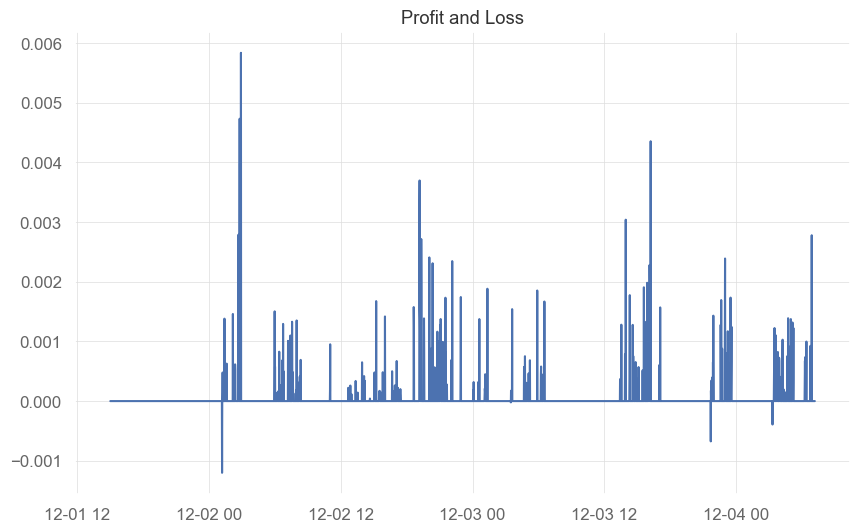

In [21]:
fig, ax = plt.subplots()

ax.set_title("Profit and Loss")
ax.plot(best_return['returns'])

plt.show()

                           Strategy
-------------------------  -----------------
Start Period               2023-12-01
End Period                 2023-12-04
Risk-Free Rate             0.0%
Time in Market             7.0%

Cumulative Return          21.88%
CAGR﹪                     6689820398431.42%

Sharpe                     2.82
Prob. Sharpe Ratio         100.0%
Smart Sharpe               2.41
Sortino                    35.35
Smart Sortino              30.24
Sortino/√2                 25.0
Smart Sortino/√2           21.38
Omega                      87.41

Max Drawdown               -0.12%
Longest DD Days            1
Volatility (ann.)          0.46%
Calmar                     55654492521602.97
Skew                       8.95
Kurtosis                   111.05

Expected Daily %           0.01%
Expected Monthly %         21.88%
Expected Yearly %          21.88%
Kelly Criterion            97.24%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.04%
Expected Shortfall (cVaR)  

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-12-02,2023-12-02,2023-12-02,1,-0.120203,-0.105301
2,2023-12-03,2023-12-03,2023-12-03,1,-0.067528,-0.050012
3,2023-12-04,2023-12-04,2023-12-04,1,-0.039260,NaN
4,2023-12-03,2023-12-03,2023-12-03,1,-0.002146,NaN


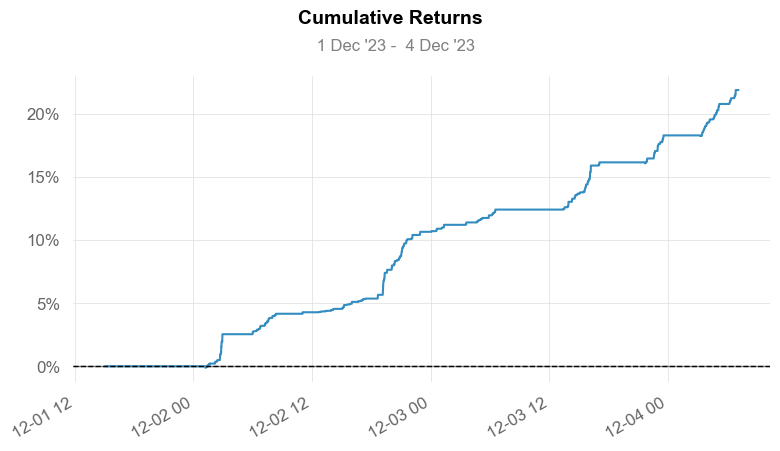

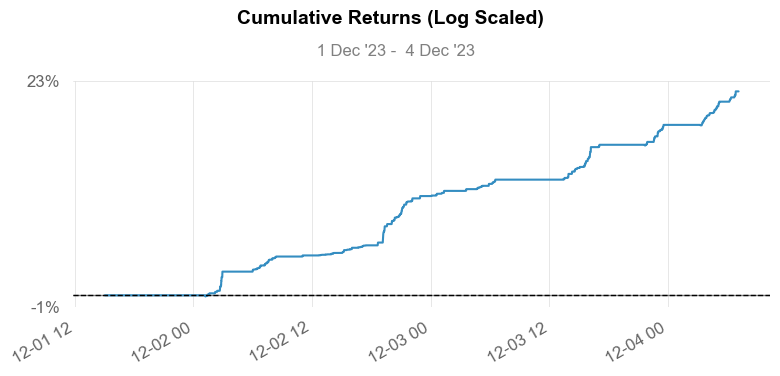

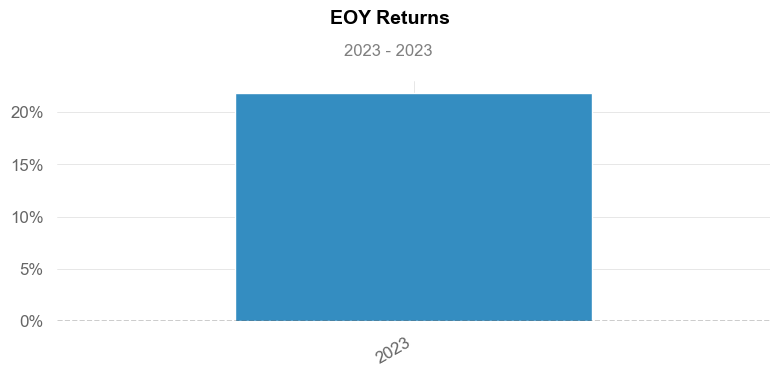

c:\Users\hyan212\Miniconda3\envs\btrl\lib\site-packages\quantstats\_plotting\core.py:516: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  _sns.kdeplot(data=combined_returns, color="black", ax=ax)


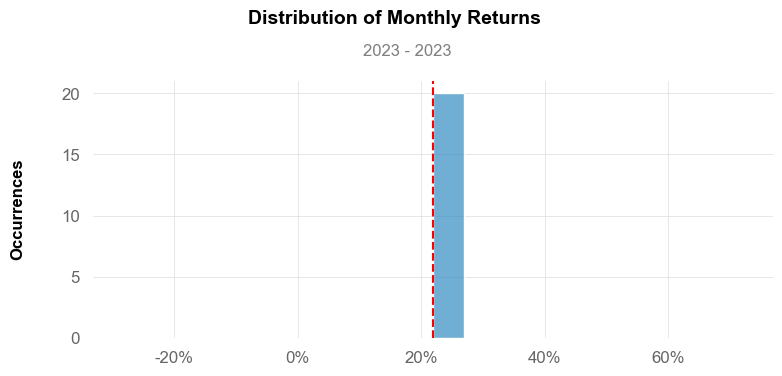

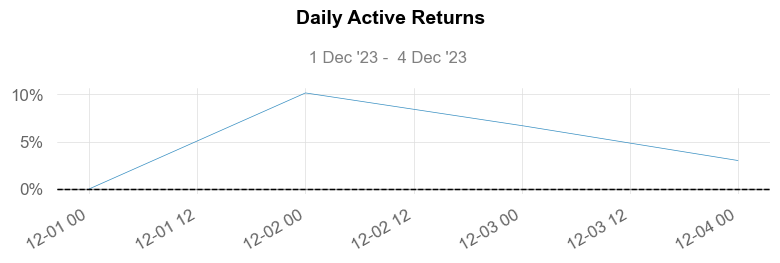

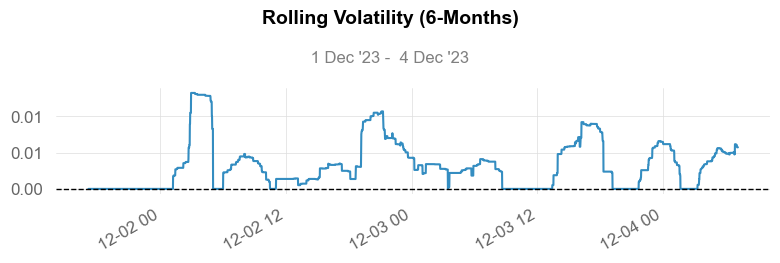

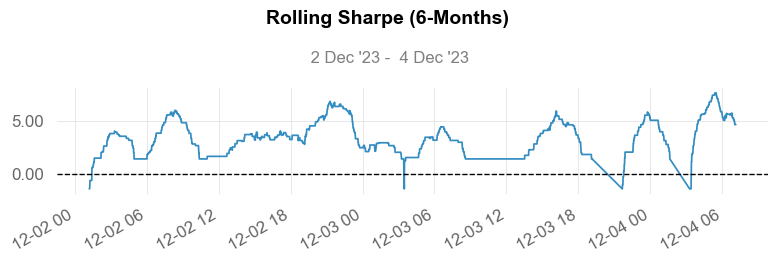

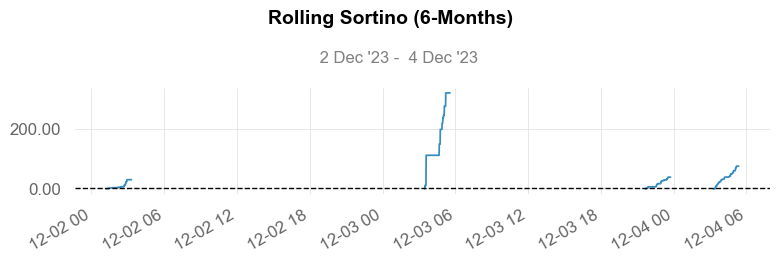

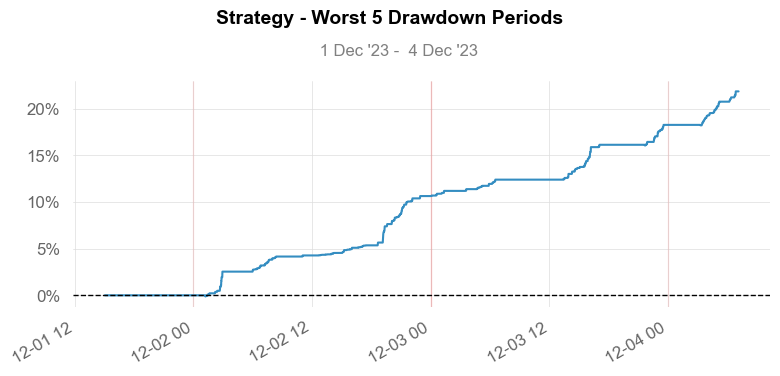

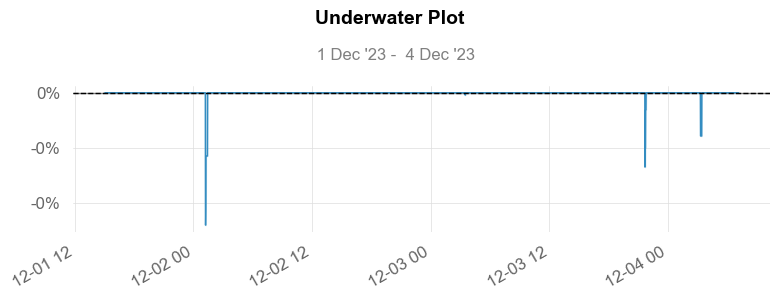

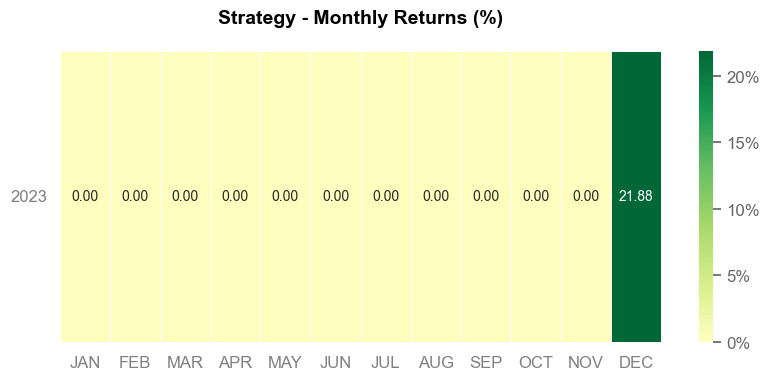

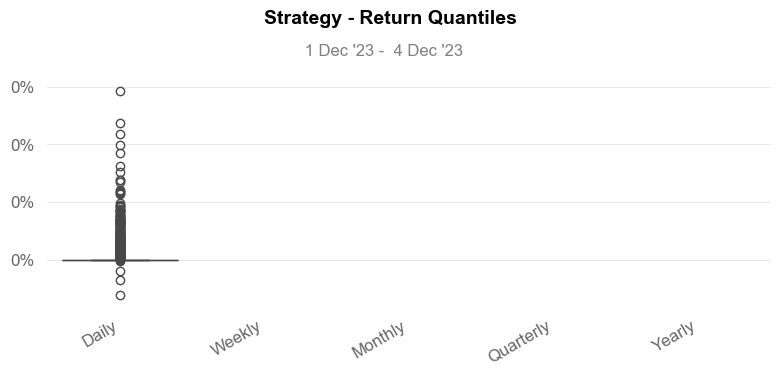

In [22]:
qs.reports.full(best_return['returns'])